---
Title: The Histogram (Part 1)
Date: 2014-07-29
Category: Data Analysis
Slug: histogram1
Summary: Thousands of words about histograms (part 1)
Math: true
---

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

When I was writing [my recent paper](http://arxiv.org/abs/1406.3020) where I infer the population of exoplanets from an incomplete catalog of noisy measurements, I spent a lot of time thinking about histograms and I came across a few cute results that I wanted to share.
Histograms are commonly used as simple "non-parametric" estimates of probability distributions but they get something of a bad rap (*binning is sinning*) because it's easy to use them inappropriately!
For example, in astronomy, it's not uncommon for people to make a histogram of their data then fit a model to the bin heights (think luminosity functions, mass functions, *etc.*) instead of just modeling the points directly.
This definitely isn't the right thing to do in that case and maybe this should be the topic of a future post but there are some situations where making a histogram of your data isn't such a bad idea.
Even if a histogram *is* a good model for the data, we're often still left with the question of what we should do in the face of incompleteness and finite measurement uncertainties.
In this post, I derive the maximum-likelihood "histogram" when your data are censored by some (known) detection efficiency function and in a later post, I'll generalize this to include a treatment of measurement uncertainties (following [Hogg, Myers & Bovy 2010](http://arXiv.org/abs/1008.4146) and [DFM, Hogg & Morton](http://arxiv.org/abs/1406.3020)).
For all the results in this post, we will fix the bin locations and widths *a priori* but it would be interesting to generalize this derivation to include adaptive widths (see, for example, [Jake VanderPlas' excellent post](http://jakevdp.github.io/blog/2012/09/12/dynamic-programming-in-python/)).

## The Maximum-Likelihood Histogram

The act of making a histogram is often thought of as a (very intuitive) *procedure*: count the number of points that fall in each bin and normalize by the bin volume to get the bin heights.
It can be difficult to generalize a procedure like this to deal with more complicated models so I prefer to think of data analysis in terms of *probabilities*.
When we do this, it's easy to derive the above procedure as the *analytic maximum-likelihood result for a specific model!*

To set this up, we have a set of $K$ data points $\{ w_k \}_{k=1}^K$ where each $w_k$ is a vector in an arbitrary number of dimensions $D$.
We're going to assume that these points are independent draws from the inhomogeneous Poisson process generated by the rate density

$$ \Gamma_\theta (w) = \frac{\mathrm{d}N}{\mathrm{d}w} $$

where $\theta$ is the set of parameters describing this function.
Under this assumption, the log-likelihood of the entire dataset is the commonly used result 

$$\ln p(\{ w_k \}_{k=1}^K\,|\,\theta) = \ell (\theta) = -\int \Gamma_\theta (w)\,\mathrm{d}w + \sum_{k=1}^K \ln \Gamma_\theta (w_k) \quad.\label{eq:poisson}
$$

This derivation is left to the interested reader… I've always wanted to say that!
A good starting place is Section 3.2 of [this PhD thesis](http://arxiv.org/abs/astro-ph/0202141).

Note that the derivation up to this point isn't specific to a histogram model and you can (and should) use a physical model for $\Gamma_\theta$ if you have one and fit for $\theta$ numerically.
But now, for the purposes of today's discussion, let's model $\Gamma_\theta$ as a piecewise constant step function

$$
\Gamma_\theta (w) = \left\{\begin{array}{ll}
    \theta_1 & w \in \Delta_1 \\
    \theta_2 & w \in \Delta_2 \\
    \vdots & \\
    \theta_N & w \in \Delta_N \\
    0 & \mathrm{otherwise}
\end{array}\right.
$$

where the $N$ parameters $\theta_n$ are the step heights and the step volumes $\Delta_n$ have been fixed in advance.
When we use this model for the rate density in the likelihood expression above (Equation $\ref{eq:poisson}$), we find

$$ \ell(\theta) = -\sum_{n=1}^N \Delta_n\,\theta_n + \sum_{k=1}^K \,\sum_{n=1}^N \mathbf{1}[w_k \in \Delta_n]\,\ln \theta_n \quad.$$

where $\Delta_n$ is the volume of the $n$-th bin and the function $\mathbf{1}[\cdot]$ is one if its argument evaluates to true and zero otherwise.

The maximum-likelihood parameters $\theta$ are the values that maximize the log-likelihood $\ell(\theta)$.
To find these, we can just compute the derivative of $\ell(\theta)$, set it to zero, and solve.
For a specific step $m$, this works out to give

$$\frac{\mathrm{d}\ell(\theta)}{\mathrm{d}\theta_m} = -\Delta_m + \frac{N_m}{\theta_m} \to \theta_m^* = \frac{N_m}{\Delta_m}$$

where $N_m = \sum_{k=1}^K \mathbf{1}[w_k \in \Delta_m]$ is the number of points that fall in the $m$-th bin.
*This is exactly what you would get if you made a histogram!*

Now we can go one step further and estimate the uncertainty $\sigma_{\theta_m^*}$ on $\theta_m^*$ using the second derivative of $\ell (\theta)$

$$\frac{\mathrm{d}^2\ell(\theta)}{{\mathrm{d}\theta_m}^2} = -\frac{N_m}{{\theta_m}^2}$$

giving

$$
\begin{eqnarray}
\sigma_{\theta_m^*}^2 &=& -\left[\frac{\mathrm{d}^2\ell(\theta)}{{\mathrm{d}\theta_m}^2}\right]_{\theta_m = \theta_m^*}^{-1} \\
&=& \frac{N_m}{\Delta_m^2}
\end{eqnarray}
$$

the familiar $\sqrt{N}$ counting statistics.

Okay. Now that we've done all this work to derive this trivial and familiar result, let's get on to generalizing it!

## The Censored Histogram

The generalization that we'll work through in this post is relevant for a lot of projects in astronomy and I expect that it occurs in many other fields too.
Suppose that you have a censored dataset where the completeness or detection efficiency $Q(w)$ is a function of the parameters $w$ and you want to determine the underlying population, not the observed distribution.
This occurs when studying the population of transiting exoplanets because smaller planets on longer periods are harder to detect than larger ones on shorter periods.
For the luminosity function of stars or quasars, this occurs because the detection efficiency scales with apparent brightness.

In what follows, we'll assume that we know (from some other means) the completeness function $Q(w)$ of our data but you could relax this and infer the parameters of $Q(w)$ simultaneously with $\theta$.
Unfortunately the result of this joint inference will no longer be analytic and, in practice, there will probably be large degeneracies.

**Inverse detection efficiency (IDE)** &nbsp;
The standard practice in these fields is to make the *weighted* histogram of the points where each point is counted with a weight inversely proportional to the detection efficiency at that point.
In other words, the estimated step height becomes

$$ \theta_m^* = \frac{1}{\Delta_m} \, \sum_{k=1}^K \frac{\mathbf{1}[w_k \in \Delta_m]}{Q(w_k)} $$

where $Q(w_k)$ is the absolute probability of detecting an object at $w_k$.
**Don't do this!**
As you'll see in a moment, while this procedure seems intuitively correct, it gives biased results and the maximum-likelihood result is actually *very simple*.

To see qualitatively why this procedure will, in general, yield biased inferences, let's consider a slightly pathological example.
In this example, there is a single bin $(0 <= w < 1)$ where the completeness function is

$$Q(w) = \frac{1}{1 + \exp((w - 0.5)/0.01)} \quad.$$

The following figure shows a plot of this example:

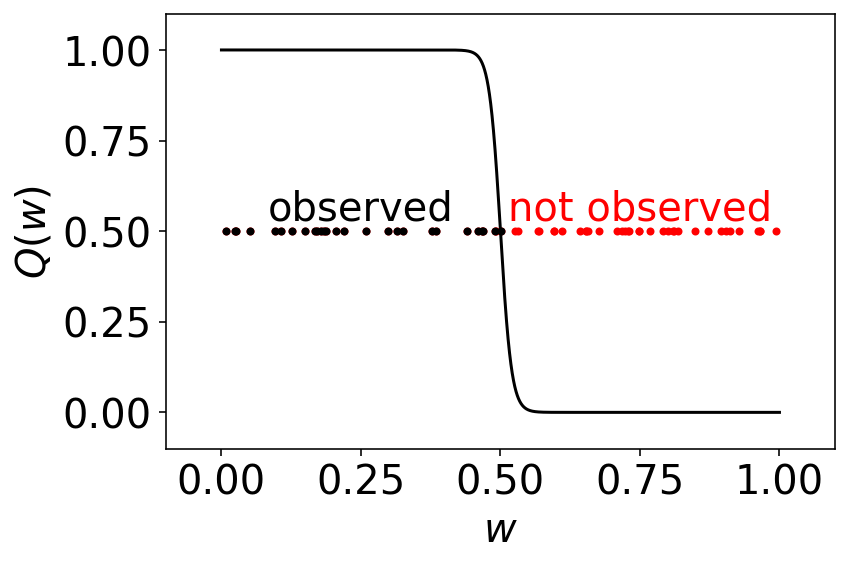

In [2]:
import numpy as np
import matplotlib.pyplot as pl
np.random.seed(12345)

# Define the completeness function.
Q = lambda w: 1.0 / (1 + np.exp((w-0.5)/0.01))

# Sample some points from a constant rate function
K = np.random.poisson(50)
w = np.random.uniform(0, 1, size=K)
wobs = w[np.random.rand(K) < Q(w)]

# Plot the observations.
pl.plot(w, 0.5*np.ones(K), ".r")
pl.plot(wobs, 0.5*np.ones(len(wobs)), ".k")
pl.text(0.25, 0.53, "observed", ha="center")
pl.text(0.75, 0.53, "not observed", ha="center", color="red")

# Plot the completeness function.
w0 = np.linspace(0, 1, 5000)
pl.plot(w0, Q(w0), "k")

pl.xlim(-0.1, 1.1)
pl.ylim(-0.1, 1.1)
pl.ylabel(r"$Q(w)$")
pl.xlabel(r"$w$");

In this figure, the black points show the locations of the points that get detected and the red points indicate points that would have been observed with a perfectly complete sample but were missed because of $Q(w)$.
If you look at the code above, you'll see that the true step height should be 50 but, if you evaluate the IDE approximation, you'll find that it gives

In [3]:
th = sum(1.0 / Q(wobs))
sigma_th = th / np.sqrt(len(wobs))
print("{0:.1f} ± {1:.1f}".format(th, sigma_th))

28.5 ± 5.5


This result is about *half* of what it should be and if you look at the figure above, I think you'll see what went wrong: only about half of the points were observed and each of those points was in a region where $Q(w) \approx 1$, meaning that each point gets a weight of 1.
It's clear that in this case each point should get a weight of 2 (or one-over-a-half) but let's see if we can derive this intuition more formally.

**The maximum-likelihood (ML) solution** &nbsp;
The first thing to note is that when we have an incomplete catalog, the likelihood of the data given the population is exactly the same as our previous expression (Equation $\ref{eq:poisson}$) but the rate $\Gamma_\theta (w)$ is replaced by the *observable rate* $\hat{\Gamma}_\theta(w) = Q(w)\,\Gamma_\theta (w)$.
Therefore, for a piecewise constant model of $\Gamma_\theta(w)$, the log-likelihood becomes

$$ \ell(\theta) = -\sum_{n=1}^N \theta_n \int_{\Delta_n} Q(w)\,\mathrm{d}w + \sum_{k=1}^K \left[\ln Q(w_k) + \sum_{n=1}^N  \mathbf{1}[w_k \in \Delta_n]\,\ln \theta_n \right] \quad.$$

As before, let's take the derivative of this with respect to a specific step height $\theta_m$ to find

$$\frac{\mathrm{d}\ell(\theta)}{\mathrm{d}\theta_m} = -\int_{\Delta_m} Q(w)\,\mathrm{d}w + \frac{N_m}{\theta_m} \to \theta_m^* = \frac{N_m}{\int_{\Delta_m}Q(w)\,\mathrm{d}w}$$

with uncertainty

$$\sigma_{\theta_m^*} = \frac{\sqrt{N_m}}{\int_{\Delta_m}Q(w)\,\mathrm{d}w} \quad.$$

This result shows that the maximum-likelihood result is also a weighted histogram but instead of weighting the points by their *per-object* completeness, the weight of each point should be the *mean completeness in that bin*.
In the limit of a constant completeness function, the IDE procedure will give the correct result but whenever the detection efficiency varies across the bin (or if there are latent dimensions; I'll come back to this in the next example), **the IDE result is just plain wrong!**
To make matters worse, as you collect more data, the IDE result gets more precise but it's still just as wrong.

Luckily, the ML solution will probably be easy to compute, even if you need to compute the weighting integrals numerically.
For our extreme example from above, the integral becomes $\sim 0.5$ and the maximum-likelihood estimate of the step height is

In [4]:
# Evaluate the completeness integral numerically.
weight = np.mean(Q(np.random.rand(50000)))

# Compute the maximum-likelihood step height.
th = len(wobs) / weight
sigma_th = th / np.sqrt(len(wobs))
print("{0:.1f} ± {1:.1f}".format(th, sigma_th))

54.0 ± 10.4


which is consistent with the correct result: 50.

## A More Realistic Example

Now that we've derived a formalism and developed some intuition for working with censored datasets, let's work through a more realistic example to see whether or not this machinery matters.
In this example, we'll add another level of complexity that is especially relevant in the study of exoplanets: latent dimensions.

For transiting exoplanets, the detection efficiency scales approximately with the signal strength times the geometric transit probability

$$Q(w) \propto \frac{R_\star}{P^{2/3}\,{M_\star}^{1/3}}\,\left[\frac{R}{R_\star}\right]^2\,\frac{1}{\sqrt{P}}$$

where $R_\star$ is the star's radius, $M_\star$ is the stellar mass, $P$ is the planet's orbital period, and $R$ is the planet's radius.
Then, if you want to measure the radius distribution of exoplanets, the standard practice is to run the one-dimensional IDE on the observed data computing the detection efficiency independently for each data point and ignoring the fact that the distribution is actually four-dimensional.
We won't work through exactly this example but instead, we'll use a simpler two-dimensional toy problem.

**The setup** &nbsp;
For this example, we'll consider a two-dimensional problem with parameters $a \in [1,\,2]$ and $b \in [1,\,10]$ where the detection efficiency is given by

$$Q(a,\,b) = 0.8 \, \left[ 1+ \exp \left(10\,\frac{a^2}{\sqrt{b}} - 10\right) \right]^{-1} \quad.$$

Here's a plot of this function:

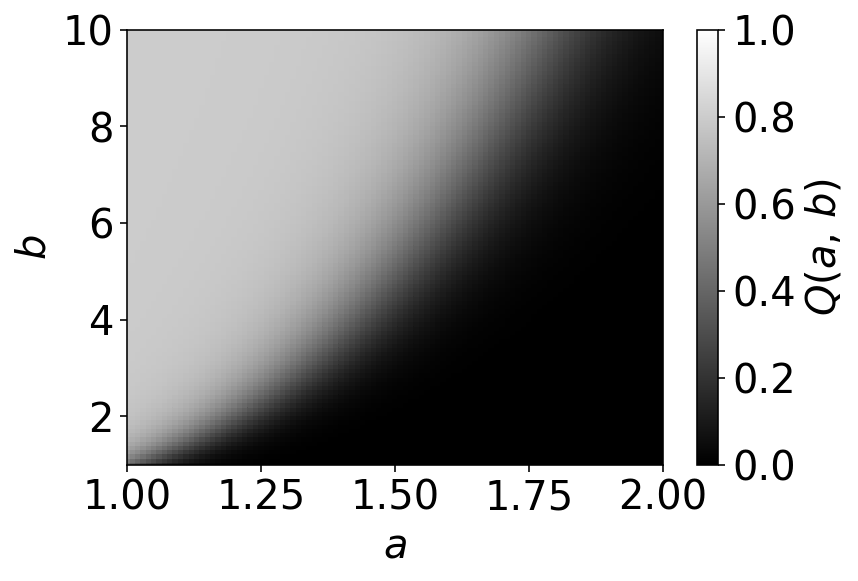

In [5]:
# Define the detection efficiency function.
def detection_efficiency(a, b):
    return 0.8 / (1 + np.exp((a**2 / np.sqrt(b) - 1) / 0.1))

# Plot this function on a grid.
amn, amx, bmn, bmx = 1, 2, 1, 10
A, B = np.meshgrid(np.linspace(amn, amx, 101), np.linspace(bmn, bmx, 103),
                   indexing="ij")
pl.pcolor(A, B, detection_efficiency(A, B), cmap="gray", vmin=0, vmax=1)
pl.xlim(amn, amx)
pl.ylim(bmn, bmx)
pl.xlabel(r"$a$")
pl.ylabel(r"$b$")
pl.colorbar(label=r"$Q(a,\,b)$");

**A synthetic dataset** &nbsp;
Now let's generate a sample dataset and censor it using this completeness function.
For simplicity, we'll use a *uniform* population where a complete sample would be uniformly distributed in $a$ and $b$:

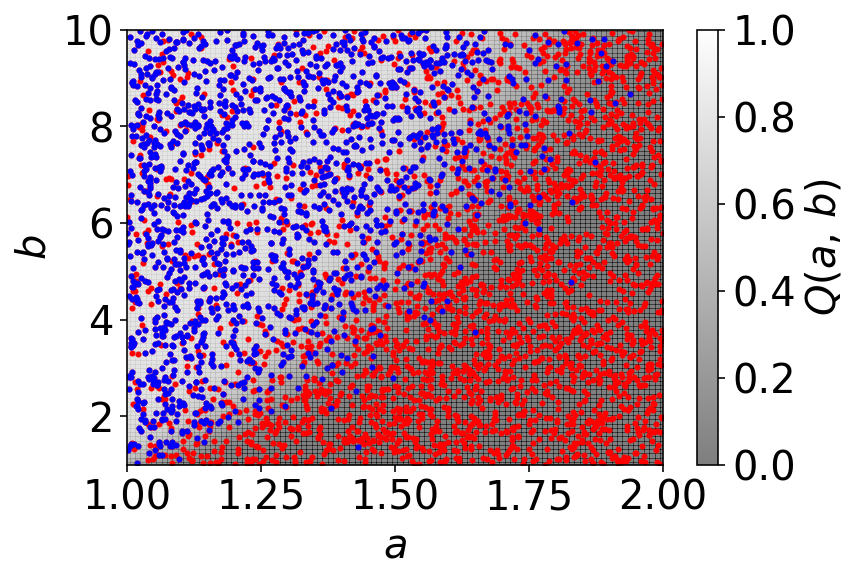

In [6]:
# Generate the true (uncensored) samples.
np.random.seed(1234)
true_rate = 500
K = np.random.poisson(true_rate * (amx - amn) * (bmx - bmn))
samples = np.vstack([
    np.random.uniform(amn, amx, size=K),
    np.random.uniform(bmn, bmx, size=K),
]).T

# Censor this dataset using the completeness function.
q = detection_efficiency(samples[:, 0], samples[:, 1])
m = np.random.rand(K) < q
dataset = samples[m]
q = q[m]

# Overplot the dataset on the completeness function. 
pl.pcolor(A, B, detection_efficiency(A, B), cmap="gray", vmin=0, vmax=1, alpha=0.5)
pl.plot(samples[:, 0], samples[:, 1], ".r", ms=4)
pl.plot(dataset[:, 0], dataset[:, 1], ".b", ms=4)
pl.xlim(amn, amx)
pl.ylim(bmn, bmx)
pl.xlabel(r"$a$")
pl.ylabel(r"$b$")
pl.colorbar(label=r"$Q(a,\,b)$");

In this figure, the blue points are objects that passed the completeness cut and made it into the catalog and the red points were missed even though they would have been detected in a complete catalog.

**Using inverse detection efficiency** &nbsp;
Now, let's say that we're only interested in the $b$ distribution and even though we know that it should be a flat line, we'll model it as a histogram with a few bins.
To start, let's look at the IDE result

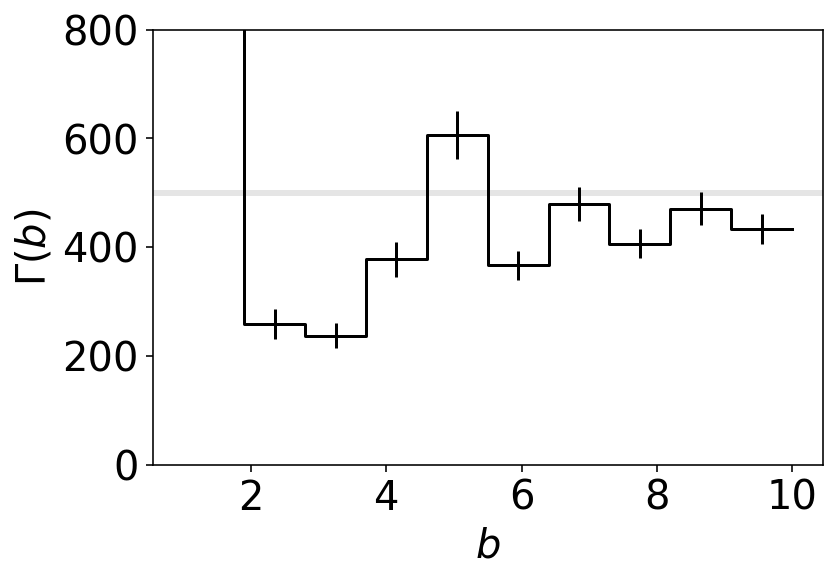

In [7]:
# Define the bins.
bin_edges = np.linspace(bmn, bmx, 11)

# Compute the inverse detection efficiency model.
n, _ = np.histogram(dataset[:, 1], bin_edges)
n_ide, _ = np.histogram(dataset[:, 1], bin_edges, weights=1.0 / q)

# This function makes a histogram plot given of a set of step heights.
def plot_hist(bin_edges, bin_heights, reluncert=None, offset=0, **kwargs):
    x = np.array(list(zip(bin_edges[:-1], bin_edges[1:]))).flatten()
    bh = bin_heights / np.diff(bin_edges)
    y = np.array(list(zip(bh, bh))).flatten()
    pl.plot(x, y, **kwargs)
    if reluncert is not None:
        pl.errorbar(0.5 * (bin_edges[:-1] + bin_edges[1:]) + offset,
                    bh, yerr=bh * reluncert, fmt="+",
                    capsize=0, color=kwargs.get("color", "k"))
        
pl.gca().axhline(true_rate, lw=3, color="k", alpha=0.1)
plot_hist(bin_edges, n_ide, reluncert=1/np.sqrt(n), color="k")
pl.xlabel(r"$b$")
pl.ylabel(r"$\Gamma(b)$")
pl.ylim(0, 800);

In this figure, the *correct* result (the rate that was used to generate the dataset) is shown as the thick gray line and the IDE estimate of this function is shown as the step function with error bars.
As expected, the estimate is noisy and the error bars seem to be overly confident (especially in the regions of lower detection efficiency).

**The maximum-likelihood** &nbsp;
For comparison, let's use the same dataset and apply the maximum-likelihood method that we derived above.
First, we need to integrate (numerically) the completeness function over the bins where the $n$-th bin is the two-dimensional area defined by

$$b_n \le b < b_{n+1} \quad \mathrm{and} \quad 1 \le a < 2 \quad.$$

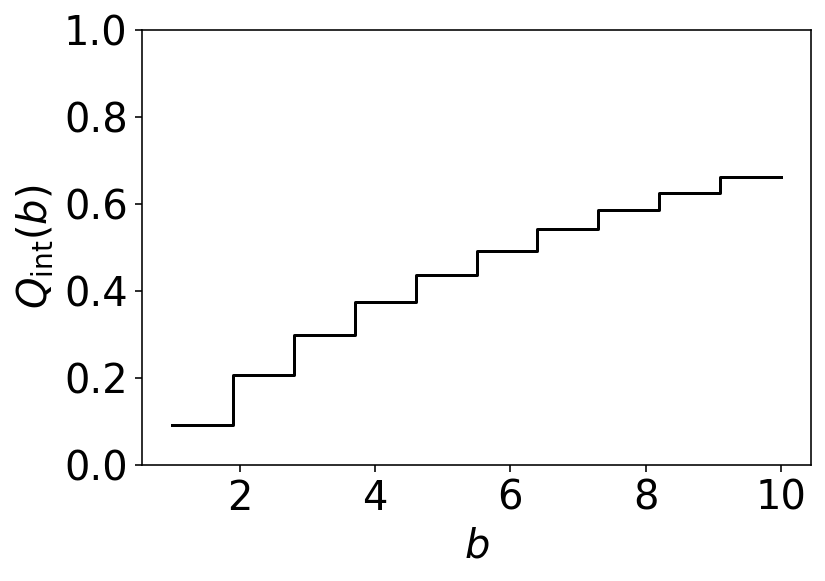

In [8]:
# Loop over the bins and numerically integrate Q(a, b) over a.
N = 50000
bq = np.empty(len(bin_edges) - 1)
a0 = np.random.uniform(amn, amx, N)
for i in range(len(bq)):
    b0 = np.random.uniform(bin_edges[i], bin_edges[i + 1], N)
    bq[i] = np.mean(detection_efficiency(a0, b0))

# Plot the integrated completeness function.
plot_hist(bin_edges, bq, color="k")
pl.xlabel(r"$b$")
pl.ylabel(r"$Q_\mathrm{int}(b)$")
pl.ylim(0, 1);

Using this integrated detection efficiency function, we can easily compute the ML step function given the prescription derived above and compare it to the IDE result.

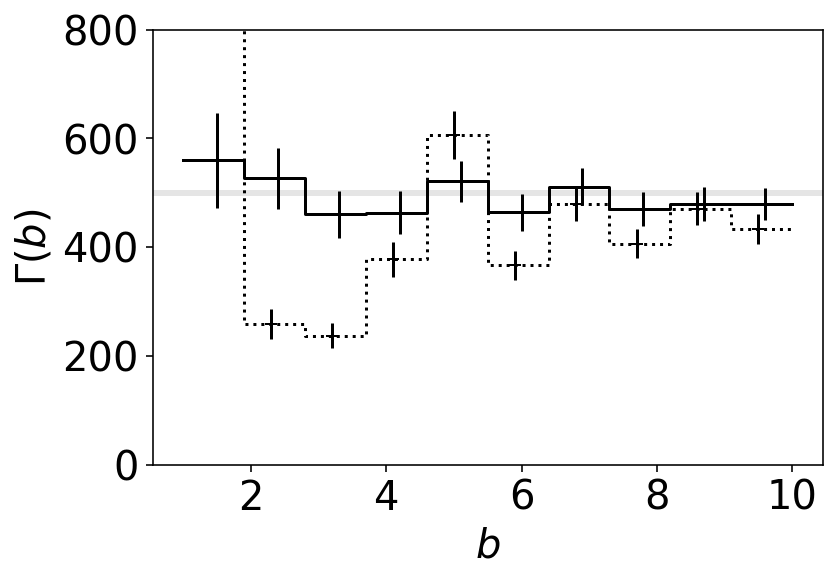

In [9]:
pl.gca().axhline(true_rate, lw=3, color="k", alpha=0.1)
plot_hist(bin_edges, n_ide, reluncert=1/np.sqrt(n), offset=-0.05,
          ls="dotted", color="k")
plot_hist(bin_edges, n / bq, reluncert=1/np.sqrt(n), offset=0.05, color="k")
pl.xlabel(r"$b$")
pl.ylabel(r"$\Gamma(b)$")
pl.ylim(0, 800);

In this figure, the IDE result is shown as a dotted line and the ML result is given by the solid black line with error bars.
As before, the correct result is shown as the thick gray line.
It's clear from this comparison that the ML result is *much* better than the IDE computation—the results are consistent with the truth!

## Summary & Conclusions

In this post, we've derived a simple, maximum-likelihood method for making histograms of incomplete datasets.
This method should *always* give less biased results—at minimal extra computational cost—than the standard techniques used in astronomy and in some cases the results will be *drastically different*.
How different the results are from the two methods is going to be very problem dependent and it's possible that the existing results in the literature aren't very wrong because of this effect.
That being said, the "correct" method isn't really any more complicated than what we're doing already so I hope that someone will read this and do The Right Thing™ next time!

Another huge benefit of casting the histogram procedure as a problem in probabilistic data analysis is that it forces us to think explicitly about our assumptions.
The result derived here is going to be the best possible result under the following assumptions:

1. The data are independent samples from an inhomogeneous Poisson process where the rate function is a piecewise constant step function,
2. the measurement uncertainties on the data are negligible, and
3. the detection efficiency function $Q(w)$ is known but it doesn't need to be constant.

In contrast, the IDE procedure is *only* correct if the detection efficiency is *constant* across each bin!
These assumptions are slightly less restrictive than the standard histogram procedure but assumption (2) is still a fairly glaring simplification and it is rarely satisfied in real astronomical datasets.
Therefore, in my next post, I'll relax the assumption of negligible uncertainties and demonstrate where and how this becomes a problem.

Let me know if you have any comments by adding it below, [tweeting at me](https://twitter.com/exoplaneteer), and/or [opening a GitHub issue](https://github.com/dfm/dfm.io/issues).

**Acknowledgments** &nbsp;
*I'd like to thank [Ruth Angus](http://ruthang.us) and [Morgan Fouesneau](https://twitter.com/mfouesneau) for useful comments.*